# **05**

In [ ]:
import pandas as pd

In [ ]:
def get_new_feature_name_df(old_feature_name_df):
  feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                columns=['dup_cnt'])

  feature_dup_df = feature_dup_df.reset_index()
  new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
  new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                                      if x[1]>0 else x[0], axis=1)

  new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
  return new_feature_name_df

In [ ]:
import pandas as pd

def get_human_dataset():
  feature_name_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/UCI HAR Dataset/features.txt', sep='\s+',
                             header=None, names=['column_index', 'column_name'])

  # 중복된 피처명 수정하는 get_new_feature_name 이용, 신규 피처명의 DataFrame 생성
  new_feature_name_df = get_new_feature_name_df(feature_name_df)

  # DataFrame에 피처명을 칼럼으로 부여하기 위해, 리스트로 변환
  feature_name = new_feature_name_df.iloc[:,1].values.tolist()

  # 학습/테스트 피처 데이터세트를 DataFrame으로 로딩, 칼럼명 feature_name
  X_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/UCI HAR Dataset/train/X_train.txt',
                        sep='\s+', header = None, names=feature_name)
  X_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/UCI HAR Dataset/test/X_test.txt',
                       sep='\s+', header = None, names=feature_name)

  # 학습/테스트 피처 데이터세트를 DataFrame으로 로딩, 칼럼명 action
  y_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/UCI HAR Dataset/train/y_train.txt',
                        sep='\s+', header = None, names=['action'])
  y_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/UCI HAR Dataset/test/y_test.txt',
                       sep='\s+', header = None, names=['action'])

  # 로드된 DataFrame 모두 반환
  return X_train, X_test, y_train, y_test

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time
import warnings

warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정, 시작 시간 설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM accuracy: {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간: {0:.4f} sec'.format(time.time() - start_time))

GBM accuracy: 0.9386
GBM 수행 시간: 939.2678 sec


In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 500],
    'learning_rate': [0.05, 0.1]
}

grid_cv = GridSearchCV(gb_clf, param_grid = params, cv=2, verbose = 1)
grid_cv.fit(X_train, y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits


In [ ]:
# GridSearchCV을 이용해 최적으로 학습된 estimator로 학습 수행
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy= accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

# **06**

In [ ]:
import xgboost as xgb
print(xgboost.__version__)


from xgboost import XGBClassifier


In [ ]:
# 위스콘신 유방암 예측

import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [ ]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [ ]:
# 학습용 데이터 80, 테스트 데이터 20

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
                                                    test_size=0.2, random_state=156)
print(X_train.shape, y_test.shape)

(455, 30) (114,)


In [ ]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [ ]:
params ={
    'max_depth':3,
    'eta':0.1,
    'objective':'binary:logistic',
    'eval_metric':'logloss',
    'early_stoppings':100
    }

num_rounds = 400


In [ ]:
# train > train, evaluation(test) > eval 명기
wlist = [(dtrain, 'train'),(dtest, 'eval')]

#하이퍼 params, early stopping params(wlist) 트레인으로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds,\
                      early_stopping_rounds=100, evals=wlist)

[01:07:17] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoppings" } are not used.

[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35415	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train-logloss:0.19218	eval-logloss:0.23156
[13]	train-logloss:0.17792	eval-logloss:0.22005
[14]	train-logloss:0.16522	eval-logloss:0.20857
[15]	train-logloss:0.15362	eval-logloss:0.19999
[16]	train-logloss:0.14333	eval-logloss:0.19012
[17]	train-logloss:0.13398	eval-logloss:0.18182
[18]	train-logloss:0.12560	eval-logloss:0.17473
[19]	

In [ ]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값(예측 확률)')
print(np.round(pred_probs[:10], 3))

# 확률 0.5보다 크면 1 아니면 0 > 리스트 preds 저장
preds = [1 if x>0.5 else 0 for x in pred_probs]
print('predictions:', preds[:10])

predict() 수행 결과값(예측 확률)
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
predictions: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score


def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix( y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)

  f1 = f1_score(y_test, pred)

  # ROC_AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)

  print('오차행렬')
  print(confusion)

  # ROC-AUC print 추가

  print('accuracy: {0:.4f}, precision:{1:.4f}, recall: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'
        .format(accuracy, precision, recall,f1,roc_auc))

In [ ]:
get_clf_eval(y_test, preds, pred_probs)

오차행렬
[[35  2]
 [ 1 76]]
accuracy: 0.9737, precision:0.9744, recall: 0.9870, F1: 0.9806, AUC: 0.9951


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

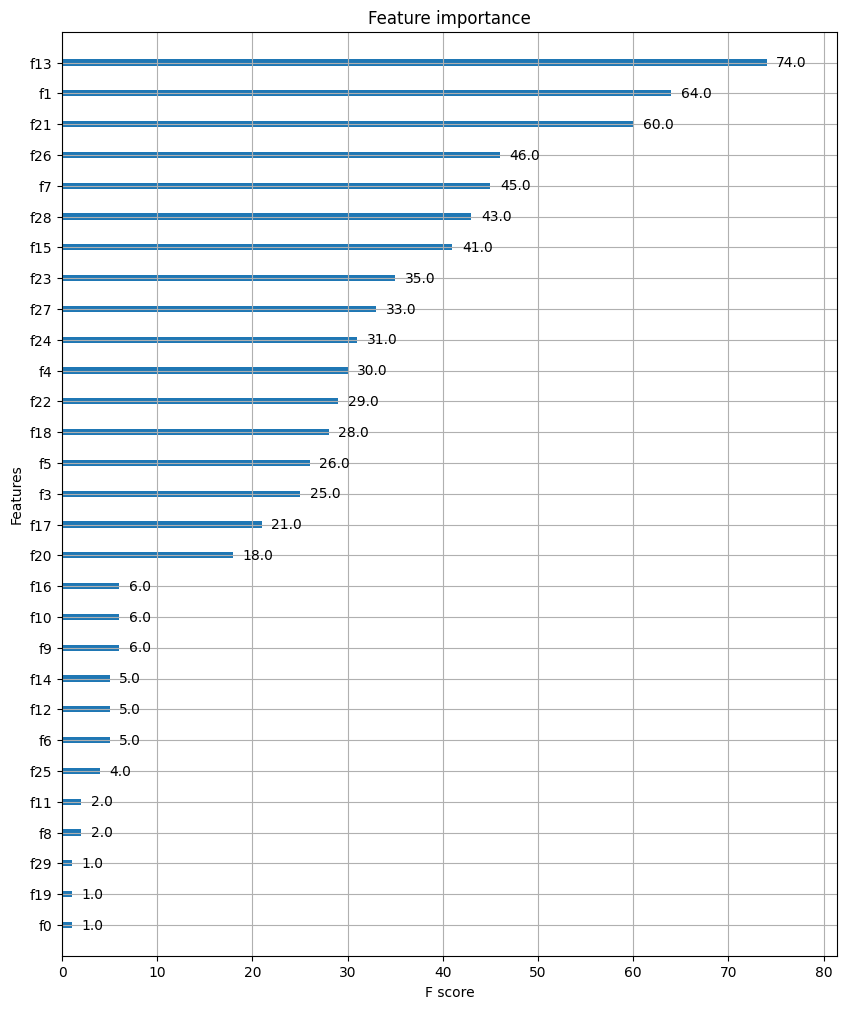

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

In [ ]:
# import sklearn Wrapper class : XGBClassifier
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimator=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, w_preds, w_pred_proba)

[01:22:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

오차행렬
[[34  3]
 [ 2 75]]
accuracy: 0.9561, precision:0.9615, recall: 0.9740, F1: 0.9677, AUC: 0.9947


In [ ]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimator=400, learning_rate=0.1, max_depth=3)

evals=[(X_test, y_test)]

xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss",
                eval_set=evals, verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]


[01:26:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27

In [ ]:

get_clf_eval(y_test, w_preds, w_pred_proba)

오차행렬
[[34  3]
 [ 2 75]]
accuracy: 0.9561, precision:0.9615, recall: 0.9740, F1: 0.9677, AUC: 0.9947


In [ ]:
# early_stopping_rounds =10
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss",
                eval_set=evals, verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, w_preds, w_pred_proba)

[01:26:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

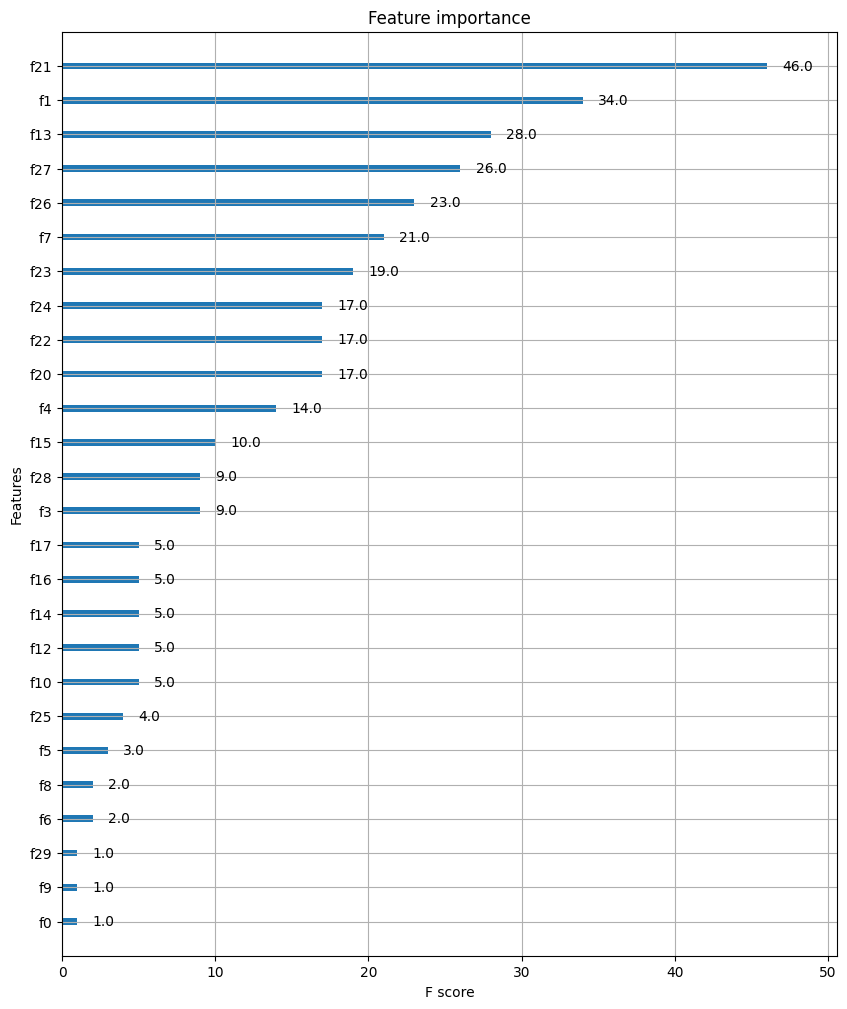

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
# 사이킷런 Wrapper클래스 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)

# **07**

In [ ]:
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2, random_state=156)

lgbm_wrapper = LGBMClassifier(n_estimator = 400)

evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss",
                 eval_set=evals, verbose=True)
preds=lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

# 왜 아규먼트가 없다고 뜰까요
# early_stopping_rounds


TypeError: ignored

In [ ]:
get_clf_eval(y_test, preds, pred_proba)

In [ ]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)


# **08**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Datasets/santander-customer-satisfaction/train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [ ]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [ ]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied : {0:.2f}'.format((unsatisfied_cnt/total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied : 0.04


In [ ]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [ ]:
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

X_features = cust_df.iloc[:,:-1]
y_labels = cust_df.iloc[:,-1]

print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print('train set, shape:{0}, test set, shape:{1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

train set, shape:(60816, 369), test set, shape:(15204, 369)
학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb_clf = XGBClassifier(n_estimator=500, random_state=156)
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[09:13:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[0]	validation_0-auc:0.82005	validation_1-auc:0.81157
[1]	validation_0-auc:0.83400	validation_1-auc:0.82452
[2]	validation_0-auc:0.83870	validation_1-auc:0.82745
[3]	validation_0-auc:0.84419	validation_1-auc:0.82922
[4]	validation_0-auc:0.84783	validation_1-auc:0.83298
[5]	validation_0-auc:0.85125	validation_1-auc:0.83500
[6]	validation_0-auc:0.85501	validation_1-auc:0.83653
[7]	validation_0-auc:0.85831	validation_1-auc:0.83782
[8]	validation_0-auc:0.86143	validation_1-auc:0.83802
[9]	validation_0-auc:0.86452	validation_1-auc:0.83914
[10]	validation_0-auc:0.86717	validation_1-auc:0.83954
[11]	validation_0-auc:0.87013	validation_1-auc:0.83983
[12]	validation_0-auc:0.87369	validation_1-auc:0.84033
[13]	validation_0-auc:0.87620	validation_1-auc:0.84055
[14]	validation_0-auc:0.87799	validation_1-auc:0.84135
[15]	validation_0-auc:0.88071	validation_1-auc:0.84117
[16]	validation_0-auc:0.88237	validation_

In [ ]:
from sklearn.model_selection import GridSearchCV

xgb_clf = XGBClassifier(n_estimators=100)

params = {
    'max_depth':[5,7],
    'min_child_weight':[1,3],
    'colsample_bytree':[0.5, 0.75]
    }

gridcv = GridSearchCV(xgb_clf, param_grid = params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])


print('최적 파라미터:', gridcv.best_params)

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test0)[:1], average='macro')
print('ROC AUC:{0:.4f}'.format(xgb_roc_score))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80289	validation_1-auc:0.80420
[1]	validation_0-auc:0.80677	validation_1-auc:0.80892
[2]	validation_0-auc:0.82161	validation_1-auc:0.81979
[3]	validation_0-auc:0.82877	validation_1-auc:0.82509
[4]	validation_0-auc:0.83227	validation_1-auc:0.82868
[5]	validation_0-auc:0.83179	validation_1-auc:0.82649
[6]	validation_0-auc:0.82662	validation_1-auc:0.81879
[7]	validation_0-auc:0.83687	validation_1-auc:0.82901
[8]	validation_0-auc:0.84136	validation_1-auc:0.83545
[9]	validation_0-auc:0.84304	validation_1-auc:0.83301
[10]	validation_0-auc:0.84221	validation_1-auc:0.83210
[11]	validation_0-auc:0.84723	validation_1-auc:0.83457
[12]	validation_0-auc:0.85187	validation_1-auc:0.83740
[13]	validation_0-auc:0.85373	validation_1-auc:0.83434
[14]	validation_0-auc:0.85631	validation_1-auc:0.83641
[15]	validation_0-auc:0.85719	validation_1-auc:0.83617
[16]	validation_0-auc:0.85906	validation_1-auc:0.83443
[17]	validation_0-auc:0.86100	validation_1-auc:0.83417
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80699	validation_1-auc:0.80599
[1]	validation_0-auc:0.81029	validation_1-auc:0.81309
[2]	validation_0-auc:0.82504	validation_1-auc:0.82148
[3]	validation_0-auc:0.83183	validation_1-auc:0.82497
[4]	validation_0-auc:0.83585	validation_1-auc:0.82786
[5]	validation_0-auc:0.83864	validation_1-auc:0.83222
[6]	validation_0-auc:0.83483	validation_1-auc:0.83054
[7]	validation_0-auc:0.84061	validation_1-auc:0.83365
[8]	validation_0-auc:0.84451	validation_1-auc:0.83729
[9]	validation_0-auc:0.84411	validation_1-auc:0.83520
[10]	validation_0-auc:0.84329	validation_1-auc:0.83367
[11]	validation_0-auc:0.84914	validation_1-auc:0.83676
[12]	validation_0-auc:0.85414	validation_1-auc:0.83983
[13]	validation_0-auc:0.85569	validation_1-auc:0.83826
[14]	validation_0-auc:0.85887	validation_1-auc:0.83916
[15]	validation_0-auc:0.85987	validation_1-auc:0.84004
[16]	validation_0-auc:0.86042	validation_1-auc:0.84034
[17]	validation_0-auc:0.86156	validation_1-auc:0.84030
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81203	validation_1-auc:0.80951
[1]	validation_0-auc:0.81450	validation_1-auc:0.81585
[2]	validation_0-auc:0.82678	validation_1-auc:0.82141
[3]	validation_0-auc:0.82958	validation_1-auc:0.82431
[4]	validation_0-auc:0.83590	validation_1-auc:0.82659
[5]	validation_0-auc:0.83743	validation_1-auc:0.82696
[6]	validation_0-auc:0.83508	validation_1-auc:0.82420
[7]	validation_0-auc:0.84130	validation_1-auc:0.82966
[8]	validation_0-auc:0.84500	validation_1-auc:0.83477
[9]	validation_0-auc:0.84551	validation_1-auc:0.83453
[10]	validation_0-auc:0.84494	validation_1-auc:0.83201
[11]	validation_0-auc:0.85031	validation_1-auc:0.83706
[12]	validation_0-auc:0.85489	validation_1-auc:0.83832
[13]	validation_0-auc:0.85636	validation_1-auc:0.83727
[14]	validation_0-auc:0.85873	validation_1-auc:0.83913
[15]	validation_0-auc:0.85979	validation_1-auc:0.83969
[16]	validation_0-auc:0.86059	validation_1-auc:0.83876
[17]	validation_0-auc:0.86171	validation_1-auc:0.83857
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80246	validation_1-auc:0.80463
[1]	validation_0-auc:0.80769	validation_1-auc:0.80995
[2]	validation_0-auc:0.82216	validation_1-auc:0.82059
[3]	validation_0-auc:0.82983	validation_1-auc:0.82797
[4]	validation_0-auc:0.83294	validation_1-auc:0.82964
[5]	validation_0-auc:0.83289	validation_1-auc:0.82807
[6]	validation_0-auc:0.82913	validation_1-auc:0.82282
[7]	validation_0-auc:0.83623	validation_1-auc:0.82949
[8]	validation_0-auc:0.84169	validation_1-auc:0.83424
[9]	validation_0-auc:0.84276	validation_1-auc:0.83206
[10]	validation_0-auc:0.84290	validation_1-auc:0.83209
[11]	validation_0-auc:0.84726	validation_1-auc:0.83490
[12]	validation_0-auc:0.85185	validation_1-auc:0.83765
[13]	validation_0-auc:0.85354	validation_1-auc:0.83497
[14]	validation_0-auc:0.85519	validation_1-auc:0.83661
[15]	validation_0-auc:0.85551	validation_1-auc:0.83619
[16]	validation_0-auc:0.85658	validation_1-auc:0.83520
[17]	validation_0-auc:0.85731	validation_1-auc:0.83493
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80418	validation_1-auc:0.81169
[1]	validation_0-auc:0.81174	validation_1-auc:0.81122
[2]	validation_0-auc:0.82946	validation_1-auc:0.82272
[3]	validation_0-auc:0.83495	validation_1-auc:0.82851
[4]	validation_0-auc:0.83721	validation_1-auc:0.82887
[5]	validation_0-auc:0.83847	validation_1-auc:0.83206
[6]	validation_0-auc:0.83511	validation_1-auc:0.83097
[7]	validation_0-auc:0.84116	validation_1-auc:0.83427
[8]	validation_0-auc:0.84533	validation_1-auc:0.83959
[9]	validation_0-auc:0.84475	validation_1-auc:0.83715
[10]	validation_0-auc:0.84396	validation_1-auc:0.83646
[11]	validation_0-auc:0.84838	validation_1-auc:0.83860
[12]	validation_0-auc:0.85328	validation_1-auc:0.84141
[13]	validation_0-auc:0.85385	validation_1-auc:0.83952
[14]	validation_0-auc:0.85744	validation_1-auc:0.84166
[15]	validation_0-auc:0.85825	validation_1-auc:0.84222
[16]	validation_0-auc:0.85867	validation_1-auc:0.84194
[17]	validation_0-auc:0.85911	validation_1-auc:0.84171
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81098	validation_1-auc:0.80916
[1]	validation_0-auc:0.81358	validation_1-auc:0.81313
[2]	validation_0-auc:0.82606	validation_1-auc:0.82075
[3]	validation_0-auc:0.83126	validation_1-auc:0.82413
[4]	validation_0-auc:0.83431	validation_1-auc:0.82739
[5]	validation_0-auc:0.83669	validation_1-auc:0.82762
[6]	validation_0-auc:0.83388	validation_1-auc:0.82326
[7]	validation_0-auc:0.83882	validation_1-auc:0.82781
[8]	validation_0-auc:0.84310	validation_1-auc:0.83488
[9]	validation_0-auc:0.84383	validation_1-auc:0.83609
[10]	validation_0-auc:0.84300	validation_1-auc:0.83454
[11]	validation_0-auc:0.84807	validation_1-auc:0.83811
[12]	validation_0-auc:0.85239	validation_1-auc:0.84034
[13]	validation_0-auc:0.85437	validation_1-auc:0.83857
[14]	validation_0-auc:0.85624	validation_1-auc:0.83976
[15]	validation_0-auc:0.85747	validation_1-auc:0.83981
[16]	validation_0-auc:0.85828	validation_1-auc:0.83989
[17]	validation_0-auc:0.85956	validation_1-auc:0.83887
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80902	validation_1-auc:0.80594
[1]	validation_0-auc:0.80814	validation_1-auc:0.80463
[2]	validation_0-auc:0.82929	validation_1-auc:0.82254
[3]	validation_0-auc:0.83621	validation_1-auc:0.82625
[4]	validation_0-auc:0.83964	validation_1-auc:0.82813
[5]	validation_0-auc:0.84237	validation_1-auc:0.82614
[6]	validation_0-auc:0.84139	validation_1-auc:0.82316
[7]	validation_0-auc:0.84976	validation_1-auc:0.82936
[8]	validation_0-auc:0.85363	validation_1-auc:0.83274
[9]	validation_0-auc:0.85616	validation_1-auc:0.82987
[10]	validation_0-auc:0.85494	validation_1-auc:0.82878
[11]	validation_0-auc:0.86353	validation_1-auc:0.83263
[12]	validation_0-auc:0.86904	validation_1-auc:0.83413
[13]	validation_0-auc:0.87058	validation_1-auc:0.83155
[14]	validation_0-auc:0.87381	validation_1-auc:0.83338
[15]	validation_0-auc:0.87435	validation_1-auc:0.83100
[16]	validation_0-auc:0.87537	validation_1-auc:0.83110
[17]	validation_0-auc:0.87745	validation_1-auc:0.82964
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80941	validation_1-auc:0.80686
[1]	validation_0-auc:0.81556	validation_1-auc:0.81361
[2]	validation_0-auc:0.83096	validation_1-auc:0.82315
[3]	validation_0-auc:0.83933	validation_1-auc:0.82851
[4]	validation_0-auc:0.84416	validation_1-auc:0.83167
[5]	validation_0-auc:0.84872	validation_1-auc:0.83320
[6]	validation_0-auc:0.84648	validation_1-auc:0.82990
[7]	validation_0-auc:0.85307	validation_1-auc:0.83396
[8]	validation_0-auc:0.85680	validation_1-auc:0.83723
[9]	validation_0-auc:0.85902	validation_1-auc:0.83808
[10]	validation_0-auc:0.85868	validation_1-auc:0.83643
[11]	validation_0-auc:0.86500	validation_1-auc:0.83869
[12]	validation_0-auc:0.87073	validation_1-auc:0.84082
[13]	validation_0-auc:0.87241	validation_1-auc:0.83814
[14]	validation_0-auc:0.87685	validation_1-auc:0.84077
[15]	validation_0-auc:0.87782	validation_1-auc:0.84085
[16]	validation_0-auc:0.87873	validation_1-auc:0.83983
[17]	validation_0-auc:0.87990	validation_1-auc:0.83837
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81702	validation_1-auc:0.81220
[1]	validation_0-auc:0.82046	validation_1-auc:0.81514
[2]	validation_0-auc:0.83453	validation_1-auc:0.82323
[3]	validation_0-auc:0.83849	validation_1-auc:0.82737
[4]	validation_0-auc:0.84346	validation_1-auc:0.82934
[5]	validation_0-auc:0.84713	validation_1-auc:0.83083
[6]	validation_0-auc:0.84430	validation_1-auc:0.82628
[7]	validation_0-auc:0.85255	validation_1-auc:0.83025
[8]	validation_0-auc:0.85662	validation_1-auc:0.83387
[9]	validation_0-auc:0.85863	validation_1-auc:0.83446
[10]	validation_0-auc:0.85883	validation_1-auc:0.83329
[11]	validation_0-auc:0.86666	validation_1-auc:0.83528
[12]	validation_0-auc:0.87216	validation_1-auc:0.83776
[13]	validation_0-auc:0.87498	validation_1-auc:0.83590
[14]	validation_0-auc:0.87717	validation_1-auc:0.83829
[15]	validation_0-auc:0.87780	validation_1-auc:0.83772
[16]	validation_0-auc:0.87851	validation_1-auc:0.83749
[17]	validation_0-auc:0.88025	validation_1-auc:0.83555
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80956	validation_1-auc:0.80714
[1]	validation_0-auc:0.81193	validation_1-auc:0.80854
[2]	validation_0-auc:0.82506	validation_1-auc:0.81970
[3]	validation_0-auc:0.83477	validation_1-auc:0.82709
[4]	validation_0-auc:0.83821	validation_1-auc:0.82847
[5]	validation_0-auc:0.84212	validation_1-auc:0.82840
[6]	validation_0-auc:0.83981	validation_1-auc:0.82187
[7]	validation_0-auc:0.84643	validation_1-auc:0.82964
[8]	validation_0-auc:0.85106	validation_1-auc:0.83246
[9]	validation_0-auc:0.85265	validation_1-auc:0.83022
[10]	validation_0-auc:0.85202	validation_1-auc:0.82886
[11]	validation_0-auc:0.85929	validation_1-auc:0.83305
[12]	validation_0-auc:0.86421	validation_1-auc:0.83632
[13]	validation_0-auc:0.86580	validation_1-auc:0.83527
[14]	validation_0-auc:0.86836	validation_1-auc:0.83751
[15]	validation_0-auc:0.86917	validation_1-auc:0.83644
[16]	validation_0-auc:0.86964	validation_1-auc:0.83589
[17]	validation_0-auc:0.87138	validation_1-auc:0.83500
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80761	validation_1-auc:0.81297
[1]	validation_0-auc:0.81426	validation_1-auc:0.81464
[2]	validation_0-auc:0.83333	validation_1-auc:0.82937
[3]	validation_0-auc:0.83932	validation_1-auc:0.83359
[4]	validation_0-auc:0.84334	validation_1-auc:0.83390
[5]	validation_0-auc:0.84685	validation_1-auc:0.83404
[6]	validation_0-auc:0.84426	validation_1-auc:0.83247
[7]	validation_0-auc:0.84963	validation_1-auc:0.83651
[8]	validation_0-auc:0.85390	validation_1-auc:0.84200
[9]	validation_0-auc:0.85566	validation_1-auc:0.84119
[10]	validation_0-auc:0.85553	validation_1-auc:0.83994
[11]	validation_0-auc:0.86125	validation_1-auc:0.84109
[12]	validation_0-auc:0.86665	validation_1-auc:0.84226
[13]	validation_0-auc:0.86779	validation_1-auc:0.84071
[14]	validation_0-auc:0.87189	validation_1-auc:0.84338
[15]	validation_0-auc:0.87286	validation_1-auc:0.84417
[16]	validation_0-auc:0.87300	validation_1-auc:0.84269
[17]	validation_0-auc:0.87369	validation_1-auc:0.84204
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81604	validation_1-auc:0.81235
[1]	validation_0-auc:0.82253	validation_1-auc:0.81400
[2]	validation_0-auc:0.83498	validation_1-auc:0.82366
[3]	validation_0-auc:0.84183	validation_1-auc:0.82843
[4]	validation_0-auc:0.84412	validation_1-auc:0.82954
[5]	validation_0-auc:0.84630	validation_1-auc:0.82708
[6]	validation_0-auc:0.84502	validation_1-auc:0.82381
[7]	validation_0-auc:0.85257	validation_1-auc:0.82814
[8]	validation_0-auc:0.85582	validation_1-auc:0.83553
[9]	validation_0-auc:0.85747	validation_1-auc:0.83650
[10]	validation_0-auc:0.85660	validation_1-auc:0.83364
[11]	validation_0-auc:0.86296	validation_1-auc:0.83958
[12]	validation_0-auc:0.86754	validation_1-auc:0.84099
[13]	validation_0-auc:0.86875	validation_1-auc:0.83850
[14]	validation_0-auc:0.87078	validation_1-auc:0.84079
[15]	validation_0-auc:0.87244	validation_1-auc:0.84106
[16]	validation_0-auc:0.87329	validation_1-auc:0.83940
[17]	validation_0-auc:0.87409	validation_1-auc:0.83849
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80593	validation_1-auc:0.80898
[1]	validation_0-auc:0.80943	validation_1-auc:0.80802
[2]	validation_0-auc:0.82441	validation_1-auc:0.82007
[3]	validation_0-auc:0.83164	validation_1-auc:0.82390
[4]	validation_0-auc:0.83772	validation_1-auc:0.82921
[5]	validation_0-auc:0.83842	validation_1-auc:0.83047
[6]	validation_0-auc:0.84104	validation_1-auc:0.83226
[7]	validation_0-auc:0.84469	validation_1-auc:0.83537
[8]	validation_0-auc:0.84683	validation_1-auc:0.83548
[9]	validation_0-auc:0.84814	validation_1-auc:0.83619
[10]	validation_0-auc:0.84998	validation_1-auc:0.83683
[11]	validation_0-auc:0.85144	validation_1-auc:0.83648
[12]	validation_0-auc:0.85391	validation_1-auc:0.83602
[13]	validation_0-auc:0.85621	validation_1-auc:0.83614
[14]	validation_0-auc:0.85711	validation_1-auc:0.83651
[15]	validation_0-auc:0.85910	validation_1-auc:0.83675
[16]	validation_0-auc:0.86083	validation_1-auc:0.83563
[17]	validation_0-auc:0.86138	validation_1-auc:0.83521
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80863	validation_1-auc:0.80011
[1]	validation_0-auc:0.80571	validation_1-auc:0.80437
[2]	validation_0-auc:0.82796	validation_1-auc:0.82018
[3]	validation_0-auc:0.83445	validation_1-auc:0.82662
[4]	validation_0-auc:0.83787	validation_1-auc:0.82864
[5]	validation_0-auc:0.84117	validation_1-auc:0.83429
[6]	validation_0-auc:0.84465	validation_1-auc:0.83836
[7]	validation_0-auc:0.84676	validation_1-auc:0.83896
[8]	validation_0-auc:0.84853	validation_1-auc:0.83854
[9]	validation_0-auc:0.85047	validation_1-auc:0.83875
[10]	validation_0-auc:0.85238	validation_1-auc:0.83996
[11]	validation_0-auc:0.85450	validation_1-auc:0.83884
[12]	validation_0-auc:0.85576	validation_1-auc:0.84019
[13]	validation_0-auc:0.85703	validation_1-auc:0.84096
[14]	validation_0-auc:0.85943	validation_1-auc:0.84124
[15]	validation_0-auc:0.86088	validation_1-auc:0.84081
[16]	validation_0-auc:0.86188	validation_1-auc:0.84113
[17]	validation_0-auc:0.86250	validation_1-auc:0.84169
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82051	validation_1-auc:0.81706
[1]	validation_0-auc:0.81489	validation_1-auc:0.81463
[2]	validation_0-auc:0.82613	validation_1-auc:0.82392
[3]	validation_0-auc:0.83159	validation_1-auc:0.82687
[4]	validation_0-auc:0.83529	validation_1-auc:0.82743
[5]	validation_0-auc:0.84072	validation_1-auc:0.83137
[6]	validation_0-auc:0.84302	validation_1-auc:0.83442
[7]	validation_0-auc:0.84511	validation_1-auc:0.83555
[8]	validation_0-auc:0.84587	validation_1-auc:0.83638
[9]	validation_0-auc:0.84812	validation_1-auc:0.83673
[10]	validation_0-auc:0.85143	validation_1-auc:0.83526
[11]	validation_0-auc:0.85397	validation_1-auc:0.83620
[12]	validation_0-auc:0.85616	validation_1-auc:0.83763
[13]	validation_0-auc:0.85783	validation_1-auc:0.83704
[14]	validation_0-auc:0.85973	validation_1-auc:0.83846
[15]	validation_0-auc:0.86155	validation_1-auc:0.83830
[16]	validation_0-auc:0.86278	validation_1-auc:0.83844
[17]	validation_0-auc:0.86419	validation_1-auc:0.83895
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80803	validation_1-auc:0.80806
[1]	validation_0-auc:0.80888	validation_1-auc:0.80894
[2]	validation_0-auc:0.82405	validation_1-auc:0.81945
[3]	validation_0-auc:0.83156	validation_1-auc:0.82609
[4]	validation_0-auc:0.83401	validation_1-auc:0.82772
[5]	validation_0-auc:0.83658	validation_1-auc:0.82950
[6]	validation_0-auc:0.84047	validation_1-auc:0.83059
[7]	validation_0-auc:0.84358	validation_1-auc:0.83185
[8]	validation_0-auc:0.84541	validation_1-auc:0.83323
[9]	validation_0-auc:0.84653	validation_1-auc:0.83440
[10]	validation_0-auc:0.84920	validation_1-auc:0.83548
[11]	validation_0-auc:0.85030	validation_1-auc:0.83627
[12]	validation_0-auc:0.85268	validation_1-auc:0.83664
[13]	validation_0-auc:0.85483	validation_1-auc:0.83676
[14]	validation_0-auc:0.85628	validation_1-auc:0.83643
[15]	validation_0-auc:0.85783	validation_1-auc:0.83561
[16]	validation_0-auc:0.85833	validation_1-auc:0.83599
[17]	validation_0-auc:0.85876	validation_1-auc:0.83658
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80906	validation_1-auc:0.80435
[1]	validation_0-auc:0.80610	validation_1-auc:0.80703
[2]	validation_0-auc:0.82829	validation_1-auc:0.82098
[3]	validation_0-auc:0.83657	validation_1-auc:0.82669
[4]	validation_0-auc:0.83911	validation_1-auc:0.82849
[5]	validation_0-auc:0.84163	validation_1-auc:0.83122
[6]	validation_0-auc:0.84566	validation_1-auc:0.83619
[7]	validation_0-auc:0.84720	validation_1-auc:0.83653
[8]	validation_0-auc:0.84844	validation_1-auc:0.83526
[9]	validation_0-auc:0.84960	validation_1-auc:0.83672
[10]	validation_0-auc:0.85155	validation_1-auc:0.83775
[11]	validation_0-auc:0.85323	validation_1-auc:0.83779
[12]	validation_0-auc:0.85457	validation_1-auc:0.83858
[13]	validation_0-auc:0.85554	validation_1-auc:0.83864
[14]	validation_0-auc:0.85653	validation_1-auc:0.83865
[15]	validation_0-auc:0.85860	validation_1-auc:0.83784
[16]	validation_0-auc:0.85972	validation_1-auc:0.83823
[17]	validation_0-auc:0.86067	validation_1-auc:0.83797
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81882	validation_1-auc:0.81739
[1]	validation_0-auc:0.81386	validation_1-auc:0.81337
[2]	validation_0-auc:0.82661	validation_1-auc:0.82334
[3]	validation_0-auc:0.83557	validation_1-auc:0.82907
[4]	validation_0-auc:0.83892	validation_1-auc:0.83167
[5]	validation_0-auc:0.84144	validation_1-auc:0.83105
[6]	validation_0-auc:0.84403	validation_1-auc:0.83360
[7]	validation_0-auc:0.84648	validation_1-auc:0.83417
[8]	validation_0-auc:0.84841	validation_1-auc:0.83581
[9]	validation_0-auc:0.84876	validation_1-auc:0.83592
[10]	validation_0-auc:0.85065	validation_1-auc:0.83624
[11]	validation_0-auc:0.85204	validation_1-auc:0.83676
[12]	validation_0-auc:0.85449	validation_1-auc:0.83495
[13]	validation_0-auc:0.85519	validation_1-auc:0.83583
[14]	validation_0-auc:0.85682	validation_1-auc:0.83720
[15]	validation_0-auc:0.85847	validation_1-auc:0.83743
[16]	validation_0-auc:0.85930	validation_1-auc:0.83756
[17]	validation_0-auc:0.86089	validation_1-auc:0.83841
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81573	validation_1-auc:0.81067
[1]	validation_0-auc:0.81402	validation_1-auc:0.80774
[2]	validation_0-auc:0.82912	validation_1-auc:0.81864
[3]	validation_0-auc:0.83834	validation_1-auc:0.82490
[4]	validation_0-auc:0.84340	validation_1-auc:0.82924
[5]	validation_0-auc:0.84800	validation_1-auc:0.83252
[6]	validation_0-auc:0.85152	validation_1-auc:0.83472
[7]	validation_0-auc:0.85737	validation_1-auc:0.83466
[8]	validation_0-auc:0.86002	validation_1-auc:0.83343
[9]	validation_0-auc:0.86333	validation_1-auc:0.83595
[10]	validation_0-auc:0.86764	validation_1-auc:0.83618
[11]	validation_0-auc:0.87055	validation_1-auc:0.83591
[12]	validation_0-auc:0.87303	validation_1-auc:0.83511
[13]	validation_0-auc:0.87531	validation_1-auc:0.83573
[14]	validation_0-auc:0.87644	validation_1-auc:0.83532
[15]	validation_0-auc:0.87864	validation_1-auc:0.83346
[16]	validation_0-auc:0.87995	validation_1-auc:0.83380
[17]	validation_0-auc:0.88099	validation_1-auc:0.83336
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81428	validation_1-auc:0.80541
[1]	validation_0-auc:0.81563	validation_1-auc:0.81177
[2]	validation_0-auc:0.83592	validation_1-auc:0.82066
[3]	validation_0-auc:0.84379	validation_1-auc:0.82740
[4]	validation_0-auc:0.85017	validation_1-auc:0.83233
[5]	validation_0-auc:0.85384	validation_1-auc:0.83517
[6]	validation_0-auc:0.85918	validation_1-auc:0.83931
[7]	validation_0-auc:0.86245	validation_1-auc:0.83779
[8]	validation_0-auc:0.86419	validation_1-auc:0.83818
[9]	validation_0-auc:0.86613	validation_1-auc:0.83712
[10]	validation_0-auc:0.86933	validation_1-auc:0.83600
[11]	validation_0-auc:0.87184	validation_1-auc:0.83711
[12]	validation_0-auc:0.87415	validation_1-auc:0.83710
[13]	validation_0-auc:0.87716	validation_1-auc:0.83639
[14]	validation_0-auc:0.87865	validation_1-auc:0.83795
[15]	validation_0-auc:0.88110	validation_1-auc:0.83841
[16]	validation_0-auc:0.88358	validation_1-auc:0.83779
[17]	validation_0-auc:0.88461	validation_1-auc:0.83794
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82448	validation_1-auc:0.81823
[1]	validation_0-auc:0.82212	validation_1-auc:0.81592
[2]	validation_0-auc:0.83464	validation_1-auc:0.82639
[3]	validation_0-auc:0.84121	validation_1-auc:0.82994
[4]	validation_0-auc:0.84804	validation_1-auc:0.83439
[5]	validation_0-auc:0.85362	validation_1-auc:0.83314
[6]	validation_0-auc:0.85620	validation_1-auc:0.83629
[7]	validation_0-auc:0.86025	validation_1-auc:0.83581
[8]	validation_0-auc:0.86252	validation_1-auc:0.83743
[9]	validation_0-auc:0.86649	validation_1-auc:0.83646
[10]	validation_0-auc:0.87101	validation_1-auc:0.83606
[11]	validation_0-auc:0.87345	validation_1-auc:0.83743
[12]	validation_0-auc:0.87701	validation_1-auc:0.83809
[13]	validation_0-auc:0.88044	validation_1-auc:0.83779
[14]	validation_0-auc:0.88136	validation_1-auc:0.83869
[15]	validation_0-auc:0.88292	validation_1-auc:0.83977
[16]	validation_0-auc:0.88460	validation_1-auc:0.83955
[17]	validation_0-auc:0.88560	validation_1-auc:0.83952
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81642	validation_1-auc:0.81216
[1]	validation_0-auc:0.81467	validation_1-auc:0.81133
[2]	validation_0-auc:0.82902	validation_1-auc:0.82239
[3]	validation_0-auc:0.83775	validation_1-auc:0.82795
[4]	validation_0-auc:0.84354	validation_1-auc:0.83096
[5]	validation_0-auc:0.84790	validation_1-auc:0.83441
[6]	validation_0-auc:0.85080	validation_1-auc:0.83508
[7]	validation_0-auc:0.85454	validation_1-auc:0.83765
[8]	validation_0-auc:0.85680	validation_1-auc:0.83712
[9]	validation_0-auc:0.85991	validation_1-auc:0.83639
[10]	validation_0-auc:0.86257	validation_1-auc:0.83788
[11]	validation_0-auc:0.86486	validation_1-auc:0.83696
[12]	validation_0-auc:0.86742	validation_1-auc:0.83751
[13]	validation_0-auc:0.86908	validation_1-auc:0.83692
[14]	validation_0-auc:0.87015	validation_1-auc:0.83647
[15]	validation_0-auc:0.87203	validation_1-auc:0.83610
[16]	validation_0-auc:0.87312	validation_1-auc:0.83591
[17]	validation_0-auc:0.87401	validation_1-auc:0.83522
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81195	validation_1-auc:0.80615
[1]	validation_0-auc:0.81510	validation_1-auc:0.81289
[2]	validation_0-auc:0.83475	validation_1-auc:0.82645
[3]	validation_0-auc:0.84423	validation_1-auc:0.83140
[4]	validation_0-auc:0.84952	validation_1-auc:0.83408
[5]	validation_0-auc:0.85317	validation_1-auc:0.83493
[6]	validation_0-auc:0.85713	validation_1-auc:0.83850
[7]	validation_0-auc:0.85924	validation_1-auc:0.83793
[8]	validation_0-auc:0.86016	validation_1-auc:0.83809
[9]	validation_0-auc:0.86307	validation_1-auc:0.83816
[10]	validation_0-auc:0.86572	validation_1-auc:0.83931
[11]	validation_0-auc:0.86748	validation_1-auc:0.83981
[12]	validation_0-auc:0.87020	validation_1-auc:0.83906
[13]	validation_0-auc:0.87270	validation_1-auc:0.84018
[14]	validation_0-auc:0.87371	validation_1-auc:0.84127
[15]	validation_0-auc:0.87558	validation_1-auc:0.84117
[16]	validation_0-auc:0.87630	validation_1-auc:0.84078
[17]	validation_0-auc:0.87673	validation_1-auc:0.84143
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82218	validation_1-auc:0.81819
[1]	validation_0-auc:0.82120	validation_1-auc:0.81682
[2]	validation_0-auc:0.83459	validation_1-auc:0.82497
[3]	validation_0-auc:0.84312	validation_1-auc:0.82940
[4]	validation_0-auc:0.84793	validation_1-auc:0.83178
[5]	validation_0-auc:0.85339	validation_1-auc:0.83203
[6]	validation_0-auc:0.85638	validation_1-auc:0.83512
[7]	validation_0-auc:0.86082	validation_1-auc:0.83538
[8]	validation_0-auc:0.86250	validation_1-auc:0.83772
[9]	validation_0-auc:0.86569	validation_1-auc:0.83589
[10]	validation_0-auc:0.86855	validation_1-auc:0.83342
[11]	validation_0-auc:0.87103	validation_1-auc:0.83398
[12]	validation_0-auc:0.87268	validation_1-auc:0.83472
[13]	validation_0-auc:0.87475	validation_1-auc:0.83576
[14]	validation_0-auc:0.87519	validation_1-auc:0.83642
[15]	validation_0-auc:0.87568	validation_1-auc:0.83708
[16]	validation_0-auc:0.87705	validation_1-auc:0.83742
[17]	validation_0-auc:0.87816	validation_1-auc:0.83725
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81270	validation_1-auc:0.81076
[1]	validation_0-auc:0.81820	validation_1-auc:0.81360
[2]	validation_0-auc:0.83353	validation_1-auc:0.83010
[3]	validation_0-auc:0.83823	validation_1-auc:0.83429
[4]	validation_0-auc:0.84125	validation_1-auc:0.83363
[5]	validation_0-auc:0.83979	validation_1-auc:0.83299
[6]	validation_0-auc:0.83796	validation_1-auc:0.83148
[7]	validation_0-auc:0.84384	validation_1-auc:0.83526
[8]	validation_0-auc:0.84676	validation_1-auc:0.83677
[9]	validation_0-auc:0.84731	validation_1-auc:0.83538
[10]	validation_0-auc:0.84726	validation_1-auc:0.83485
[11]	validation_0-auc:0.85253	validation_1-auc:0.84007
[12]	validation_0-auc:0.85678	validation_1-auc:0.84255
[13]	validation_0-auc:0.85821	validation_1-auc:0.84121
[14]	validation_0-auc:0.86100	validation_1-auc:0.84394
[15]	validation_0-auc:0.86250	validation_1-auc:0.84436
[16]	validation_0-auc:0.86371	validation_1-auc:0.84416
[17]	validation_0-auc:0.86531	validation_1-auc:0.84329
[18]	validation_0-au

AttributeError: ignored

In [ ]:
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=7,
                        min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

xgb_clf.fit(X_train, y_train, early_stopping_rounds=200,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])


xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test0)[:1], average='macro')
print('ROC AUC:{0:.4f}'.format(xgb_roc_score))

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_feature=20, height=0.4)

In [ ]:
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators=500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=200,
            eval_metric="auc", eval_set=evals)

xgb_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test0)[:1], average='macro')
print('ROC AUC:{0:.4f}'.format(xgb_roc_score))


In [ ]:
from sklearn.model_selection import GriSearchCV

lgbm_clf = LGBMClassifier(n_estimators=200)

parms = {'num_leaves':[32, 64],
         'max_depth':[128, 160],
         'min_child_samples':[60, 100],
         'subsample':[0.8, 1]}

gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_round=30, eval_metric="auc",
           eval_set=[(X-train, y_train), (X_test, y_test)])


lgbm_roc_score = roc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

In [ ]:
lgbm_clf = LGBMClassifier(n_estimator=100, num_leaves=32, sumbsample=0.8, min_child_sample=100,
                          max_depth=128)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stooping_round=100, eval_metric="auc", eval_set=eval,
             verbose=True)

lgbm_roc_score = roc_auc_score(y_tesr, lgbm_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

In [ ]:
conda install -c conda-forge imbalanced-learn

In [ ]:
imfort pandas as pd
imfort numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('./creditcard.csv')
card_df.head(3)

In [ ]:
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df=None):
  df_copy = df.copy()
  df_copy.drop('Time', axis=1, inplace=True)
  return df_copy

In [ ]:
def get_train_test_dataset(df=None):

  df_copy = get_preprocessed_df(df)

  X_feature = df_copy.iloc[:, :-1]
  y_target = df_copy.iloc[:, :-1]

  X_train, X_test, y_train, y_test = /
  train_test_sprit(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)

  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [ ]:
print(y_train.value_count()/y_train.shape[0]*100)

print(y_test.value_count()/y_test.shape[0]*100)

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fix(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lrc_clf.predict_proba(X_tset)[:, 1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

In [ ]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train, tgt_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_preba(frt_test)[:, 1]
  get_clf_eval(tgt_test, pred, pred_preba)

In [ ]:
from lighrdbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leavers=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

In [ ]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None):
  df_copy = df.copy()
  scaler = StandardScaler()
  amount_n = scaler.flt_transform(df_copy['Amount'].values.reshape(-1, 1))

  df_copy.insert(0, 'Amount_Scaled', amount_n)

  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  return df_copy

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test-X_test, tgt_train=y_train,
                     tgt_test=y_test)

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

In [ ]:
def get_preprocessed_df(df=None):
    df_dopy = df.copy()

    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('###로지스틱 회귀 예측 성능###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train
                     tgt_test=y_test)

print('###LightGBM 예측 성능###')
get_model_train_eval(lgbm_, ftr_train=X_train, ftr_test, tgt_train=y_train,
                     tgt_test=y_test)

In [ ]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr=card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [ ]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
  fraud = df[df['Class']==1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)

  iqr_weight = iqr*weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight

  outlier_index = fraud[(fraud<lowest_val)|(fraud>highest_val)].index
  return outlier_index

In [ ]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('outlier data index', outlier_index)

In [ ]:
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)

  outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
  df_copy.drop(outlier_index, axis = 1, inplace = True)

  return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test = X_test, tgt_train = y_train,
                     tgt_test = y_test)

get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test = X_test, tgt_train = y_train,
                     tgt_test = y_test)

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print(X_train.shape, y_train.shape)
print(X_train_over.shape, y_train_over.shape)
print(pd.Series(y_train_over).value_counts())

In [ ]:
lr_clf = LogisticRegression()

get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test = X_test, tgt_train = y_train_over,
                     tgt_test = y_test)

In [ ]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leabes=64, n_jobs=-1, boot_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                     tgt_train=y_train_over, tgt_test=y_test)

In [ ]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)


In [ ]:
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state = 0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

lr_final = LogisticRegression(C=10)

knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print(accuracy_score(y_test, knn_pred))
print(accuracy_score(y_test, rf_pred))
print(accuracy_score(y_test, dt_pred))
print(accuracy_score(y_test, ada_pred))

In [ ]:
pred = np.array([knn_clf,rf_clf,dt_clf,ada_clf])
print(pred.shape)

pred = np.transpose(pred)
print(pred.shape)

In [ ]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print(accuracy_score(y_test, final))

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)

  train_fold_pred = np.zeros((X_train_n.shape[0], 1))
  test_pred = np.zeros((X_test_n.shape[0], n_folds))
  print(model.__class__.__name__)

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    print(folder_counter)
    X_tr = X_train_n[train_index]
    y_tr = X_train_n[train_index]
    X_te = X_train_n[valid_index]

    model.tir(X_tr, y_tr)
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
    test_pred[:,folder_counter] = model.predict(X_test_n)

  test_pred_mean = np.mean(test_pred, axis = 1).reshape(-1,1)

  return train_fold_pred, test_pred_mean

knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, fr_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_train, dt_train, ada_train), axis=1)



In [ ]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print(accuracy_score(y_test, stack_final))